<a href="https://colab.research.google.com/github/AsmaaYassinDev/Context-Aware-Fraud-Detection/blob/main/train_isolation_forest_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- STEP 1: CHECKING DATA ---
⚠️ Data not found. Starting Download...
Please upload 'kaggle.json' file now:


Saving kaggle.json to kaggle.json
 58% 69.0M/118M [00:00<00:00, 710MB/s]
100% 118M/118M [00:00<00:00, 548MB/s] 
Archive:  ieee-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test_identity.csv       
  inflating: test_transaction.csv    
  inflating: train_identity.csv      
  inflating: train_transaction.csv   
unzip:  cannot find or open train_transaction.csv.zip, train_transaction.csv.zip.zip or train_transaction.csv.zip.ZIP.
unzip:  cannot find or open train_identity.csv.zip, train_identity.csv.zip.zip or train_identity.csv.zip.ZIP.
✅ Download & Unzip Complete.
Loading CSVs into Memory...


/tmp/ipython-input-1058268635.py:53: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-1058268635.py:53: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-1058268635.py:53: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-1058268635.py:53: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-1058268635.py:53: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-105826


--- STEP 2: BEHAVIORAL PROFILING & PREPROCESSING ---


/tmp/ipython-input-1058268635.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['hour'] = (df['TransactionDT'] // 3600) % 24
/tmp/ipython-input-1058268635.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['UID'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['P_emaildomain'].astype(str)


Total Transactions: 590,540
Unique UIDs Created: 90,375
Grouping Efficiency: 0.8470


/tmp/ipython-input-1058268635.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['User_Trans_Count'] = df.groupby('UID').cumcount() + 1
/tmp/ipython-input-1058268635.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['User_Mean_Amt'] = df.groupby('UID')['TransactionAmt'].transform(lambda x: x.expanding().mean())
/tmp/ipython-input-1058268635.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

✅ Features Created (Leakage-Free).

--- STEP 3: SPLITTING & TRAINING (STRICT 80:20) ---
Training Set (First 80%): 472,432 rows
Testing Set  (Last 20%):  118,108 rows
Training Model on 100,000 samples from Historical Data...
✅ Training Complete.

--- STEP 4: TESTING ON FUTURE DATA (LAST 20%) ---

Classification Report (Test Set):
                   precision    recall  f1-score   support

           Normal       0.97      0.96      0.97    114044
Potential Anomaly       0.16      0.20      0.18      4064

         accuracy                           0.94    118108
        macro avg       0.57      0.58      0.57    118108
     weighted avg       0.94      0.94      0.94    118108

Unsupervised ROC-AUC Score (Test Set): 0.7702


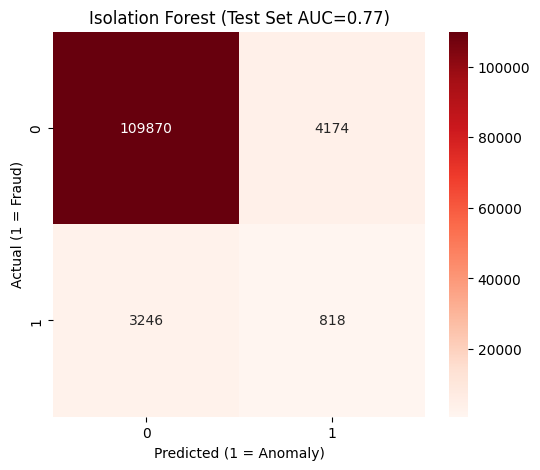

In [1]:
# ==========================================
# 5. UNSUPERVISED MODEL: ISOLATION FOREST
# METHODOLOGY: 80:20 TIME-SERIES SPLIT (Strict)
# ==========================================

import os
import gc
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ---------------------------------------------------------
# STEP 1: ROBUST DATA LOADING
# ---------------------------------------------------------
print("--- STEP 1: CHECKING DATA ---")

def force_download():
    if os.path.exists('train_transaction.csv'):
        print("✅ Data found. Loading...")
        return

    print("⚠️ Data not found. Starting Download...")
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Please upload 'kaggle.json' file now:")
        uploaded = files.upload()
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

    !kaggle competitions download -c ieee-fraud-detection
    !unzip -o ieee-fraud-detection.zip
    !unzip -o train_transaction.csv.zip
    !unzip -o train_identity.csv.zip
    print("✅ Download & Unzip Complete.")

force_download()

def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
    return df

print("Loading CSVs into Memory...")
train_trans = reduce_mem_usage(pd.read_csv('train_transaction.csv'))
train_id = reduce_mem_usage(pd.read_csv('train_identity.csv'))
df = pd.merge(train_trans, train_id, on='TransactionID', how='left')
del train_trans, train_id
gc.collect()

# ---------------------------------------------------------
# STEP 2: FEATURE ENGINEERING (LEAKAGE-FREE)
# ---------------------------------------------------------
print("\n--- STEP 2: BEHAVIORAL PROFILING & PREPROCESSING ---")

# 1. Sort by Time (Crucial for Time-Series logic)
df = df.sort_values('TransactionDT').reset_index(drop=True)

# A. Filtering
df = df.drop(columns=df.columns[df.isnull().mean() > 0.95])
df = df.drop(columns=df.nunique()[df.nunique() == 1].index)

# B. Imputation
for col in df.select_dtypes(include=['object']).columns: df[col] = df[col].fillna('Unknown')
for col in df.select_dtypes(exclude=['object']).columns: df[col] = df[col].fillna(-1)

# C. Timezone Fix
if 'id_14' in df.columns: df['id_14'] = df['id_14'].astype(str)

# D. Encoding
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# E. User Profiling (Your Innovation)
df['hour'] = (df['TransactionDT'] // 3600) % 24
df['UID'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['P_emaildomain'].astype(str)

# --- ENTITY RESOLUTION RIGOR CHECK ---
total_transactions = len(df)
unique_uids = df['UID'].nunique()
grouped_data_percentage = (total_transactions - unique_uids) / total_transactions
print(f"Total Transactions: {total_transactions:,}")
print(f"Unique UIDs Created: {unique_uids:,}")
print(f"Grouping Efficiency: {grouped_data_percentage:.4f}")
# -------------------------------------

# F. Advanced Features (Using Expanding Windows to prevent Future Leakage)
# Velocity
df['User_Trans_Count'] = df.groupby('UID').cumcount() + 1
# Spending Deviation
df['User_Mean_Amt'] = df.groupby('UID')['TransactionAmt'].transform(lambda x: x.expanding().mean())
df['Amt_Deviation'] = df['TransactionAmt'] / (df['User_Mean_Amt'] + 1e-5)
# Time Behavior
df['User_Hour_Mean'] = df.groupby(['UID', 'hour'])['TransactionAmt'].transform(lambda x: x.expanding().mean())
df['Time_Behavior_Deviation'] = df['TransactionAmt'] / (df['User_Hour_Mean'] + 1e-5)

print("✅ Features Created (Leakage-Free).")

# ---------------------------------------------------------
# STEP 3: 80:20 TIME-SERIES SPLIT & TRAINING
# ---------------------------------------------------------
print("\n--- STEP 3: SPLITTING & TRAINING (STRICT 80:20) ---")

# 1. Define Split Point
split_idx = int(len(df) * 0.8)

# 2. Create Train (Historical) and Test (Future)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Training Set (First 80%): {len(train_df):,} rows")
print(f"Testing Set  (Last 20%):  {len(test_df):,} rows")

# 3. Define Features to use (Exclude Meta-data)
exclude = ['isFraud', 'TransactionID', 'TransactionDT', 'UID', 'User_Mean_Amt', 'User_Hour_Mean']
features = [c for c in df.columns if c not in exclude]

X_train = train_df[features]
X_test = test_df[features]
y_test = test_df['isFraud'] # Ground truth for validation

# 4. Train Isolation Forest on TRAINING DATA ONLY
# We use a sample of 100k from the TRAIN set to keep Colab fast and avoid RAM crashes.
# This does NOT violate the split, because the sample comes strictly from the 80% historical data.
X_train_sample = X_train.sample(n=100000, random_state=42)

print(f"Training Model on {len(X_train_sample):,} samples from Historical Data...")
model = IsolationForest(
    n_estimators=300,
    max_samples='auto',
    contamination=0.035, # Assuming ~3.5% fraud rate
    random_state=42,
    n_jobs=-1,
    verbose=0
)

model.fit(X_train_sample)
print("✅ Training Complete.")

# ---------------------------------------------------------
# STEP 4: EVALUATION ON FUTURE DATA
# ---------------------------------------------------------
print("\n--- STEP 4: TESTING ON FUTURE DATA (LAST 20%) ---")

# Predict on the TEST SET
# Decision Function: lower is more abnormal. We flip it (-) so higher = more likely fraud
y_scores = -model.decision_function(X_test)

# Convert scores to binary predictions (1=Fraud, 0=Normal) based on the model's internal threshold
y_pred_raw = model.predict(X_test)
y_pred = [1 if x == -1 else 0 for x in y_pred_raw]

# Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Potential Anomaly']))

# ROC-AUC
auc = roc_auc_score(y_test, y_scores)
print(f"Unsupervised ROC-AUC Score (Test Set): {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f'Isolation Forest (Test Set AUC={auc:.2f})')
plt.xlabel("Predicted (1 = Anomaly)")
plt.ylabel("Actual (1 = Fraud)")
plt.show()

--- 📊 CALCULATING FEATURE IMPORTANCE (SHAP) ---
This may take 1-2 minutes. Calculating contributions for the Test Set...

Total Features in Model: 426

--- 📊 RANKING OF YOUR ENGINEERED FEATURES (ISOLATION FOREST) 📊 ---
Feature Name              | Rank  | Impact Score | Status
-----------------------------------------------------------------
User_Trans_Count          | #35   | 0.0162       | 🔹 SUPPORTIVE (Useful)
Amt_Deviation             | #236  | 0.0063       | 🔸 WEAK (Shadowed)
Time_Behavior_Deviation   | #33   | 0.0166       | 🔹 SUPPORTIVE (Useful)
User_Mean_Amt             | ----  | 0.0000       | ❌ NOT USED
User_Hour_Mean            | ----  | 0.0000       | ❌ NOT USED
hour                      | #11   | 0.0215       | ✅ STRONG (Core)

--- 🏆 COMPARISON WITH #1 FEATURE ---
Top Feature is: D10 (Score: 0.0314)

--- GENERATING SHAP SUMMARY PLOT ---


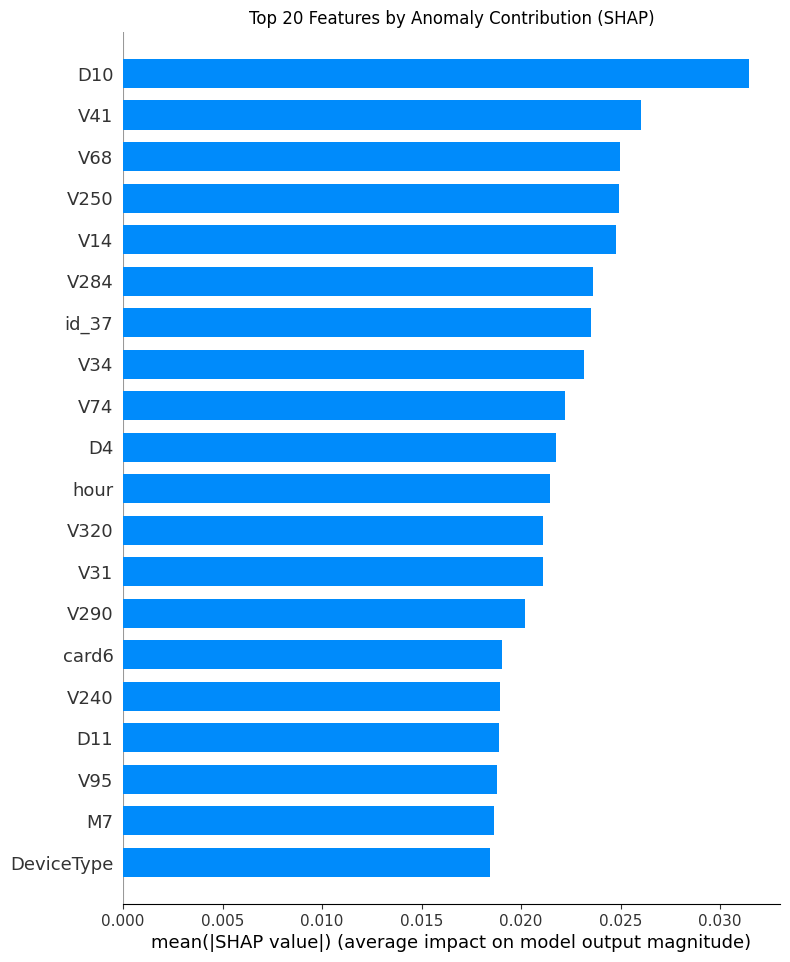

In [2]:
# ==========================================
# THESIS VALIDATION: ISOLATION FOREST FEATURE RANKING (VIA SHAP)
# ==========================================
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# 1. Install SHAP (Uncomment if running in Colab)
# !pip install shap

print("--- 📊 CALCULATING FEATURE IMPORTANCE (SHAP) ---")
print("This may take 1-2 minutes. Calculating contributions for the Test Set...")

# 2. Calculate Importance using SHAP
# We use TreeExplainer because Isolation Forest is a tree-based model
explainer = shap.TreeExplainer(model)

# We calculate SHAP values on a sample of X_test (calculating on all rows is too slow)
# 5,000 samples is statistically sufficient for a thesis ranking
X_sample = X_test.sample(n=5000, random_state=42)
shap_values = explainer.shap_values(X_sample)

# 3. Process SHAP Values into a Ranking DataFrame
# SHAP returns a matrix. We take the mean absolute value for each feature.
# High mean |SHAP| = High contribution to anomaly score.
feature_names = X_test.columns
mean_shap = np.abs(shap_values).mean(axis=0)

imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain': mean_shap  # We call it 'Gain/Impact' for consistency
}).sort_values(by='Gain', ascending=False).reset_index(drop=True)

# Add Rank
imp_df['Rank'] = imp_df.index + 1

# 4. Define Your Engineered Features to Track
my_features = [
    'User_Trans_Count',         # Velocity
    'Amt_Deviation',            # Contextual Spending
    'Time_Behavior_Deviation',  # Contextual Timing
    'User_Mean_Amt',            # User Habit
    'User_Hour_Mean',           # User Context
    'hour',                     # Temporal
]

print(f"\nTotal Features in Model: {len(imp_df)}")
print("\n--- 📊 RANKING OF YOUR ENGINEERED FEATURES (ISOLATION FOREST) 📊 ---")
print(f"{'Feature Name':<25} | {'Rank':<5} | {'Impact Score':<12} | {'Status'}")
print("-" * 65)

found_features = []
for feat in my_features:
    if feat in imp_df['Feature'].values:
        row = imp_df[imp_df['Feature'] == feat].iloc[0]
        rank = int(row['Rank'])
        gain = row['Gain']

        # Thesis Interpretation Status
        # Top 10 in unsupervised is excellent because it competes with Vesta features
        if rank <= 5: status = "🌟 STAR (Top 5)"
        elif rank <= 20: status = "✅ STRONG (Core)"
        elif rank <= 50: status = "🔹 SUPPORTIVE (Useful)"
        else: status = "🔸 WEAK (Shadowed)"

        # Note: SHAP values are small (e.g., 0.05), so we format with 4 decimals
        print(f"{feat:<25} | #{rank:<4} | {gain:<12.4f} | {status}")
        found_features.append(feat)
    else:
        print(f"{feat:<25} | ----  | 0.0000       | ❌ NOT USED")

# 5. Quick Stats for Discussion
top_feat = imp_df.iloc[0]
print("\n--- 🏆 COMPARISON WITH #1 FEATURE ---")
print(f"Top Feature is: {top_feat['Feature']} (Score: {top_feat['Gain']:.4f})")

# 6. Generate Summary Plot (Great for Thesis Images)
print("\n--- GENERATING SHAP SUMMARY PLOT ---")
plt.figure()
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Top 20 Features by Anomaly Contribution (SHAP)")
plt.show()